In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from skimage import io
import numpy as np
import torchvision
import torchvision.transforms as transforms
import warnings
import torchvision.models as models
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],
                        std=[0.25,0.25,0.25])
])

class butterfly_dataset(Dataset):
    def __init__(self,csv_file,root_dir,transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
        self.label_encoder = LabelEncoder()
        self.annotations['label_encoded'] = self.label_encoder.fit_transform(self.annotations['label'])
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self,index):
        img_path = os.path.join(self.root_dir,self.annotations.iloc[index,0])
        image = io.imread(img_path)
        image = Image.fromarray(image)
        #y_label = torch.tensor(int(self.annotations.iloc[index,1]))
        y_label = torch.tensor(int(self.annotations.iloc[index, 2]))
        if self.transform:
            image = self.transform(image)
            
        return (image,y_label)

In [3]:
train_pth = '/kaggle/input/butterfly-image-classification/Training_set.csv'
#tst_pth = '/kaggle/input/butterfly-image-classification/Testing_set.csv'
train_root_dir = '/kaggle/input/butterfly-image-classification/train'
#test_root_dir = '/kaggle/input/butterfly-image-classification/test'

train_dataset = butterfly_dataset(train_pth,train_root_dir,transform=transform)
#test_dataset = butterfly_dataset(tst_pth,test_root_dir,transform=transform)

In [4]:
train_dataloader = DataLoader(train_dataset,batch_size=16,shuffle=True)
#test_dataloader = DataLoader(test_dataset, batch_size=8)

In [5]:
df = pd.read_csv(train_pth)
df['label'].nunique()

75

In [6]:
model = models.resnet50(weights=True)

#Freeze the weights of the ResNet50 model
for params in model.parameters():
    params.requires_grad = False
    
num_classes = 75
model.fc = nn.Linear(model.fc.in_features, num_classes)

## Setting up the optimizers
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(),lr=0.0005,momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 83.4MB/s]


In [7]:
num_epochs = 20

# Move the model to GPU
model.to(device)

# Define dictionaries to store training and testing metrics
train_metrics = {'loss': [], 'accuracy': []}
test_metrics = {'loss': [], 'accuracy': []}

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    model.train()  # Set the model to training mode
    for images, labels in train_dataloader:
        # Move the data to the GPU
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass + backward pass + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        # Store the statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_accuracy = 100 * correct / total

    train_metrics['loss'].append(train_loss)
    train_metrics['accuracy'].append(train_accuracy)

    # Print training statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

Epoch [1/20], Train Loss: 3.8313, Train Accuracy: 22.14%
Epoch [2/20], Train Loss: 2.8462, Train Accuracy: 58.50%
Epoch [3/20], Train Loss: 2.1732, Train Accuracy: 72.12%
Epoch [4/20], Train Loss: 1.7481, Train Accuracy: 77.80%
Epoch [5/20], Train Loss: 1.4620, Train Accuracy: 80.86%
Epoch [6/20], Train Loss: 1.2621, Train Accuracy: 82.80%
Epoch [7/20], Train Loss: 1.1254, Train Accuracy: 83.83%
Epoch [8/20], Train Loss: 1.0209, Train Accuracy: 84.24%
Epoch [9/20], Train Loss: 0.9353, Train Accuracy: 85.94%
Epoch [10/20], Train Loss: 0.8693, Train Accuracy: 86.18%
Epoch [11/20], Train Loss: 0.8110, Train Accuracy: 86.91%
Epoch [12/20], Train Loss: 0.7712, Train Accuracy: 87.55%
Epoch [13/20], Train Loss: 0.7253, Train Accuracy: 88.01%
Epoch [14/20], Train Loss: 0.6873, Train Accuracy: 88.38%
Epoch [15/20], Train Loss: 0.6515, Train Accuracy: 89.32%
Epoch [16/20], Train Loss: 0.6223, Train Accuracy: 89.29%
Epoch [17/20], Train Loss: 0.6138, Train Accuracy: 89.43%
Epoch [18/20], Train Lo

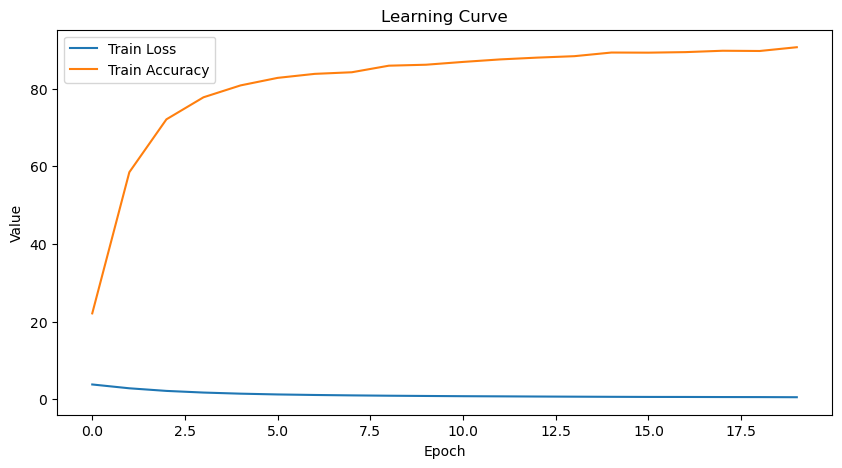

In [8]:
# Plot the learning curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_metrics['loss'], label='Train Loss')
plt.plot(train_metrics['accuracy'], label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Learning Curve')
plt.legend()
plt.show()